In [13]:
!pip install -q transformers torch evaluate rouge_score sacrebleu pandas numpy

import pandas as pd
import numpy as np
import time
import torch
from transformers import pipeline
import evaluate

In [14]:
models = ["microsoft/DialoGPT-small",
          "microsoft/DialoGPT-medium",
          "facebook/opt-350m",
          "gpt2"]

test_data = [
    {"prompt": "Hello! How are you doing today?", "reference": "I am doing well, thank you for asking! How about you?"},
    {"prompt": "Can you explain what a black hole is?", "reference": "A black hole is a region in space where gravity is so strong that nothing, not even light, can escape."},
    {"prompt": "I'm feeling a bit bored, what should I do?", "reference": "You could try reading a book, going for a walk, or learning a new hobby!"}
]

In [15]:
rouge_metric = evaluate.load('rouge')
bleu_metric = evaluate.load('bleu')

def get_model_performance(model_name,data):
    task = "text2text-generation" if "blenderbot" in model_name else "text-generation"
    pipe = pipeline(task,model=model_name,device=-1)
    total_rouge,total_bleu,total_time = 0,0,0

    for item in data:
        start_time = time.time()
        gen_args = {"max_new_tokens":30,"truncation":True}
        if pipe.tokenizer.pad_token_id is None:
            gen_args["pad_token_id"] = pipe.tokenizer.eos_token_id

        output = pipe(item['prompt'],**gen_args)[0]['generated_text']
        latency = time.time()-start_time
        response = output.replace(item['prompt'],"").strip()
        if not response:
          response = output.strip()
        if not response:
            r_score,b_score = 0,0
        else:
            r_score = rouge_metric.compute(predictions=[response],references=[item['reference']])['rougeL']
            try:
                b_score = bleu_metric.compute(predictions=[response],references=[item['reference']])['bleu']
            except:
                b_score = 0

        total_rouge += r_score
        total_bleu += b_score
        total_time += latency

    return [total_rouge/len(data),total_bleu/len(data),total_time/len(data)]

results_list = []
for m in models:
    print(f"Testing {m}...")
    try:
        metrics = get_model_performance(m,test_data)
        results_list.append(metrics)
    except Exception as e:
        print(f"Error testing {m}: {e}")
        results_list.append([0.0, 0.0, 10.0])

Testing microsoft/DialoGPT-small...


Loading weights:   0%|          | 0/149 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie transformer.wte.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
GPT2LMHeadModel LOAD REPORT from: microsoft/DialoGPT-small
Key                              | Status     |  | 
---------------------------------+------------+--+-
transformer.h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Both `max_new_tokens` (=30) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=30) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more

Testing microsoft/DialoGPT-medium...


Loading weights:   0%|          | 0/293 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie transformer.wte.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
GPT2LMHeadModel LOAD REPORT from: microsoft/DialoGPT-medium
Key                              | Status     |  | 
---------------------------------+------------+--+-
transformer.h.{0...23}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Both `max_new_tokens` (=30) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=30) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for mor

Testing facebook/opt-350m...


Loading weights:   0%|          | 0/388 [00:00<?, ?it/s]

Both `max_new_tokens` (=30) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=30) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=30) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Testing gpt2...


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Both `max_new_tokens` (=30) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=30) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=30) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_c

In [16]:
def calculate_topsis(matrix, weights, impacts):
    norm_matrix = matrix / np.sqrt((matrix**2).sum(axis=0))
    weighted_matrix = norm_matrix*weights
    best_ideal = []
    worst_ideal = []
    for i in range(len(impacts)):
        if impacts[i] == '+':
            best_ideal.append(max(weighted_matrix[:,i]))
            worst_ideal.append(min(weighted_matrix[:,i]))
        else:
            best_ideal.append(min(weighted_matrix[:,i]))
            worst_ideal.append(max(weighted_matrix[:,i]))

    dist_best = np.sqrt(((weighted_matrix - best_ideal)**2).sum(axis=1))
    dist_worst = np.sqrt(((weighted_matrix - worst_ideal)**2).sum(axis=1))

    return dist_worst / (dist_best + dist_worst)

In [17]:
matrix = np.array(results_list)
df = pd.DataFrame(matrix, columns=['ROUGE-L','BLEU','Latency'],index=models)
weights = np.array([0.35,0.35,0.30])
impacts = ['+','+','-']
df['Topsis_Score'] = calculate_topsis(matrix,weights,impacts)
df['Rank'] = df['Topsis_Score'].rank(ascending=False).astype(int)
print("\n--- FINAL CONVERSATIONAL MODEL RANKING ---")
print(df.sort_values(by='Rank'))


--- FINAL CONVERSATIONAL MODEL RANKING ---
                            ROUGE-L      BLEU    Latency  Topsis_Score  Rank
gpt2                       0.172509  0.048265   2.102799      0.938479     1
microsoft/DialoGPT-small   0.173669  0.000000   3.057614      0.394463     2
facebook/opt-350m          0.144467  0.000000   5.163953      0.347553     3
microsoft/DialoGPT-medium  0.200336  0.000000  16.293035      0.116531     4


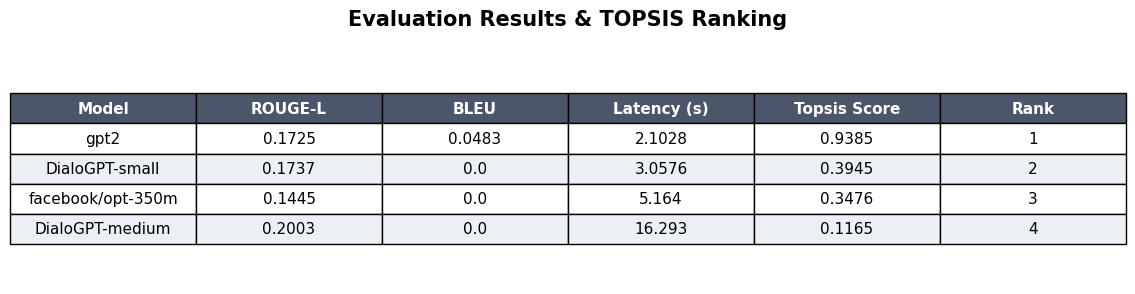

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Model': ["gpt2","DialoGPT-small","facebook/opt-350m","DialoGPT-medium"],
    'ROUGE-L': [0.1725, 0.1737, 0.1445, 0.2003],
    'BLEU': [0.0483, 0.0000, 0.0000, 0.0000],
    'Latency (s)': [2.1028, 3.0576, 5.1640, 16.2930],
    'Topsis Score': [0.9385, 0.3945, 0.3476, 0.1165],
    'Rank': [1, 2, 3, 4]
}
df_final = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_final.values, colLabels=df_final.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4c566a')
    elif row > 0:
        if row % 2 == 0:
            cell.set_facecolor('#eceff4')

plt.title('Evaluation Results & TOPSIS Ranking', fontsize=15, pad=20, weight='bold')
plt.savefig('topsis_results_table.png', bbox_inches='tight', dpi=300)
plt.show()

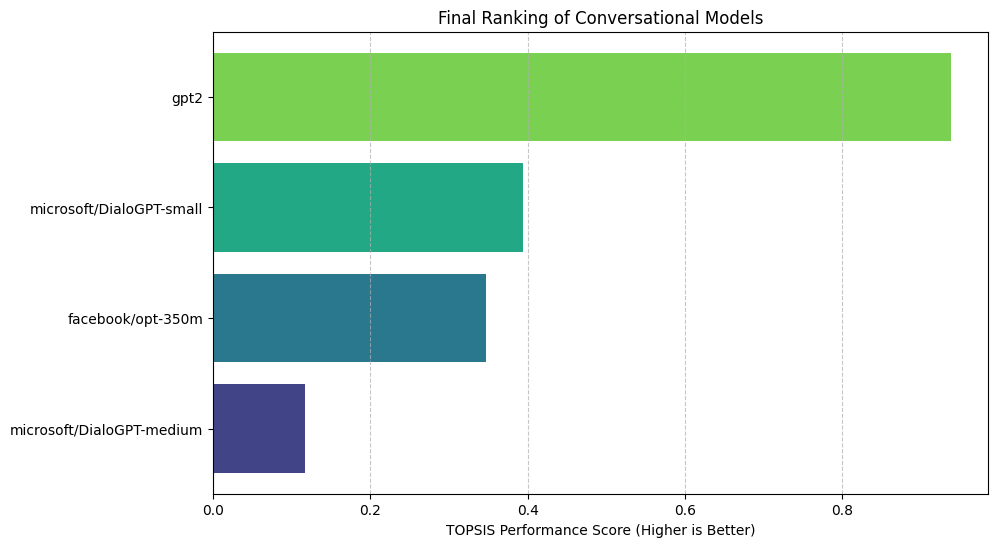

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = df.sort_values(by='Topsis_Score', ascending=True)

plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(df_sorted))
plt.barh(df_sorted.index, df_sorted['Topsis_Score'], color=colors)
plt.xlabel('TOPSIS Performance Score (Higher is Better)')
plt.title('Final Ranking of Conversational Models')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

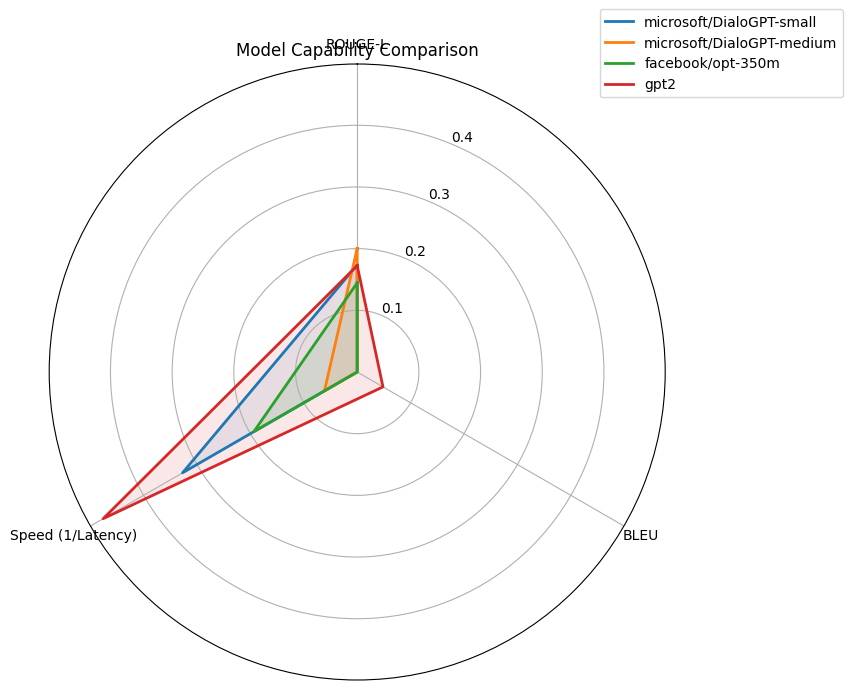

In [24]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['ROUGE-L', 'BLEU', 'Speed (1/Latency)']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for model in df.index:
    values = [df.loc[model, 'ROUGE-L'], df.loc[model, 'BLEU'], 1/df.loc[model, 'Latency']]
    values = [v/max(1, v) for v in values]
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=model)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title('Model Capability Comparison')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()